In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta
import holidays

In [95]:
def curr_monthly_expiry_date(current_date):

    ''' 
    This function will find the nearest monthlly expiry
    which will be used to find the current month future

    input format: Timestamp('2023-06-01 00:00:00')
    output format: Timestamp('2023-06-29 00:00:00')
    
    '''
    # # Define a list of holidays (you can expand this list based on your requirements)
    # holidays = ['2024-08-29',  # Example holiday on a Thursday
    #             '2024-08-28',  # Example holiday on a Wednesday
    # # Add other holidays in 'YYYY-MM-DD' format
    # ]
    # # Convert current_date to a datetime object if it's not already
    # current_date = pd.to_datetime(current_date)

    #Extract Year from timestamp format
    yr = current_date.year
 
    # Get the last day of the current month
    last_day_of_month = current_date + pd.offsets.MonthEnd(0)
    
    # Find the weekday of the last day of the month (0=Monday, 1=Tuesday, ..., 6=Sunday)
    weekday_last_day = last_day_of_month.weekday()
    
    # Calculate the difference to the last Thursday (3=Thursday)
    days_to_last_thursday = (weekday_last_day - 3) % 7
    
    # Subtract the difference to find the last Thursday of the month
    last_thursday = last_day_of_month - pd.Timedelta(days=days_to_last_thursday)

    # Check if the last Thursday is a holiday and adjust accordingly
    expiry_date = last_thursday

    while expiry_date.strftime('%Y-%m-%d') in holidays.holidays(year=yr):
        expiry_date -= timedelta(days=1)
    
    return expiry_date


In [227]:
def curr_next_weekly_expiry(current_date):
    ''' 
     This Finction will find the 'CURRENT Weekly EXPIRY (Thursday)' and 'NEXT TO NEXT EXPIRY DATE' for Nifty 50
    THe expiry date will occurs on thrusday, if there is holyday on thrusday then expiry date will be 
    the prier to the thrusday
    
    input format: Timestamp('2023-06-01 00:00:00')
    output format: Timestamp('2023-06-01 00:00:00')
    '''
    # Extract the year from the current date
    yr = current_date.year

    # Get the weekday of the current date
    weekday_current_date = current_date.weekday()

#For Current Expiry
    # Calculate the difference to the next Thursday (3=Thursday)
    days_to_next_thursday = (3 - weekday_current_date) % 7
    # Find the nearest Thursday
    next_thursday = current_date + pd.Timedelta(days=days_to_next_thursday)
    # Adjust for holidays: if Thursday is a holiday, shift to the previous day
    curr_expiry_date = next_thursday

    while curr_expiry_date.strftime('%Y-%m-%d') in holidays.holidays(yr):
      curr_expiry_date -= timedelta(days=1)

#For Next Expiry
    days_to_next_next_thursday = 7 + (3 - weekday_current_date) % 7 # 7 added because we have to find the next to next Thrusday
    # Find the next Thursday
    next_to_next_thursday = current_date + pd.Timedelta(days=days_to_next_next_thursday)
    # Adjust for holidays: if Thursday is a holiday, shift to the previous day
    next_expiry_date = next_to_next_thursday

    while next_expiry_date.strftime('%Y-%m-%d') in holidays.holidays(yr):
      next_expiry_date -= timedelta(days=1)

    return curr_expiry_date, next_expiry_date

In [228]:
curr_exp, next_exp = curr_weekly_expiry_date(curr_date)

In [229]:
curr_exp

Timestamp('2023-06-01 00:00:00')

In [230]:
next_exp

Timestamp('2023-06-08 00:00:00')

In [98]:
#Read data
data = pd.read_csv('data/NIFTY_01-06-2023.csv')

In [99]:
data['date'] = pd.to_datetime(data['date'], format="%d-%m-%Y")
data['exp_date'] = pd.to_datetime(data['exp_date'], format="%d-%b-%Y")

In [192]:
#Find current date from dataframe 
curr_date = data['date'].iloc[0]

In [101]:
monthly_exp = curr_monthly_expiry_date(curr_date)

In [102]:
monthly_exp

Timestamp('2023-06-29 00:00:00')

In [103]:
data.columns

Index(['symbol', 'date', 'time', 'trading_symbol', 'instrument', 'exp_date',
       'option_type', 'strike_price', 'open', 'high', 'low', 'close',
       'intvwap', 'intv', 'intoi', 'v', 'oi', 'ssboe', 'stat'],
      dtype='object')

In [232]:

def curr_fut_close(data):
    #FINDING INDEX CLOSE PRICE
    ''' 
    This Function will Extract Curr Future close price from intraday nifty data,
    which is daily downloaded fron FINWESIYA
    The Out put columns will be ['symbol', 'date', 'time', 'curr_fut_close']
    '''
    #FINDING CURRENT MONTH FUTURE CLOSE PRICE
    temp_fut_df = data[(data['instrument']=='FUTIDX') & (data['exp_date']==monthly_exp) & (data['time'] >= '09:15:00')]\
        [['date', 'time' ,'close']].reset_index(drop=True)

    temp_fut_df['datetime'] = temp_fut_df['date'].astype(str) + ' ' + temp_fut_df['time'].astype(str)
    temp_fut_df.sort_values(by='time', inplace=True, ascending=True)
    temp_fut_df.set_index('datetime', inplace=True)
    temp_fut_df.drop(columns=['date', 'time'], inplace=True)
    temp_fut_df.rename(columns={'close': 'curr_fut_close'}, inplace=True)

    return temp_fut_df

In [233]:
def index_close(data):
    #FINDING INDEX CLOSE PRICE
    ''' 
    This Function will Extract Index close price from intraday nifty data,
    which is daily downloaded fron FINWESIYA
    The Out put columns will be ['symbol', 'date', 'time', 'index_close']
    '''

    temp_index_df = data[(data['instrument']=='INDEX') & (data['time'] >= '09:15:00')] \
        [['symbol', 'date', 'time', 'close']].reset_index(drop=True)

    temp_index_df.sort_values(by='time', inplace=True, ascending=True)
    # Combine 'date' and 'time' columns into a single datetime column
    # strdd_df['datetime'] = pd.to_datetime(strdd_df['date'] + ' ' + strdd_df['time'])
    temp_index_df['datetime'] = temp_index_df['date'].astype(str) + ' ' + temp_index_df['time'].astype(str)

    # Set the new 'datetime' column as the index
    temp_index_df.set_index('datetime', inplace=True)

    #Rename column name
    temp_index_df.rename(columns={'close': 'index_close'}, inplace=True)

    return temp_index_df

In [231]:
index_df.columns

Index(['symbol', 'date', 'time', 'index_close'], dtype='object')

In [200]:
#Merget two dataframe based on matching key=Index. merging INDEX AND FUTURE DATAFRAME
index_fut_df = index_df.join(curr_fut_df, how='left')
# # Perform a left join on the index
# result = df1.merge(df2, how='left', left_index=True, right_index=True)
index_fut_df['strike_price'] = round(index_fut_df['index_close']/50)*50

In [205]:
index_fut_df['strike_price'] = round(index_fut_df['index_close']/50)*50

In [141]:
curr_exp = curr_weekly_expiry_date(curr_date)

In [142]:
index_fut_df.head()

,symbol,date,time,index_close,curr_fut_close,strike_price
datetime,,,,,,
2023-06-01 09:15:00,NIFTY,2023-06-01,09:15:00,18530.80,18602.55,18550.0
2023-06-01 09:16:00,NIFTY,2023-06-01,09:16:00,18550.55,18619.80,18550.0
2023-06-01 09:17:00,NIFTY,2023-06-01,09:17:00,18551.20,18622.05,18550.0
2023-06-01 09:18:00,NIFTY,2023-06-01,09:18:00,18549.65,18620.30,18550.0
2023-06-01 09:19:00,NIFTY,2023-06-01,09:19:00,18559.95,18628.50,18550.0


In [137]:
#Filtering call option data for current expiry and only keep required features
curr_call = data[(data['exp_date']==curr_exp) & (data['option_type'] == 'CE')][['date', 'time', 'strike_price', 'close']]
curr_call.rename(columns={'close':'curr_ce_close'}, inplace=True)
#Filtering put option data for current expiry and only keep required features
curr_put = data[(data['exp_date']==curr_exp) & (data['option_type'] == 'PE')][['date', 'time', 'strike_price', 'close']]
curr_put.rename(columns={'close':'curr_pe_close'}, inplace=True)

In [143]:
strdd_df = index_fut_df.merge(curr_call, on=['date', 'time', 'strike_price']).merge(curr_put, on=['date', 'time', 'strike_price'])

strdd_df['curr_strdd_close'] = strdd_df['curr_ce_close'] + strdd_df['curr_pe_close'] 

In [157]:
strdd_df.head(20)

,symbol,date,time,index_close,curr_fut_close,strike_price,curr_ce_close,curr_pe_close,curr_strdd_close,datetime,minute
0,NIFTY,2023-06-01,1900-01-01 09:15:00,18530.80,18602.55,18550.0,31.20,51.10,82.30,2023-06-01 09:15:00,15
1,NIFTY,2023-06-01,1900-01-01 09:16:00,18550.55,18619.80,18550.0,37.70,40.45,78.15,2023-06-01 09:16:00,16
2,NIFTY,2023-06-01,1900-01-01 09:17:00,18551.20,18622.05,18550.0,39.05,38.65,77.70,2023-06-01 09:17:00,17
3,NIFTY,2023-06-01,1900-01-01 09:18:00,18549.65,18620.30,18550.0,38.35,38.60,76.95,2023-06-01 09:18:00,18
4,NIFTY,2023-06-01,1900-01-01 09:19:00,18559.95,18628.50,18550.0,41.95,34.10,76.05,2023-06-01 09:19:00,19
5,NIFTY,2023-06-01,1900-01-01 09:20:00,18554.05,18625.85,18550.0,40.50,35.25,75.75,2023-06-01 09:20:00,20
6,NIFTY,2023-06-01,1900-01-01 09:21:00,18548.80,18621.40,18550.0,37.65,36.50,74.15,2023-06-01 09:21:00,21
7,NIFTY,2023-06-01,1900-01-01 09:22:00,18547.05,18619.70,18550.0,35.70,38.25,73.95,2023-06-01 09:22:00,22
8,NIFTY,2023-06-01,1900-01-01 09:23:00,18540.30,18615.00,18550.0,34.15,40.05,74.20,2023-06-01 09:23:00,23
9,NIFTY,2023-06-01,1900-01-01 09:24:00,18538.70,18615.25,18550.0,33.50,39.90,73.40,2023-06-01 09:24:00,24


In [148]:
strdd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   symbol            375 non-null    object        
 1   date              375 non-null    datetime64[ns]
 2   time              375 non-null    object        
 3   index_close       375 non-null    float64       
 4   curr_fut_close    375 non-null    float64       
 5   strike_price      375 non-null    float64       
 6   curr_ce_close     375 non-null    float64       
 7   curr_pe_close     375 non-null    float64       
 8   curr_strdd_close  375 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 26.5+ KB


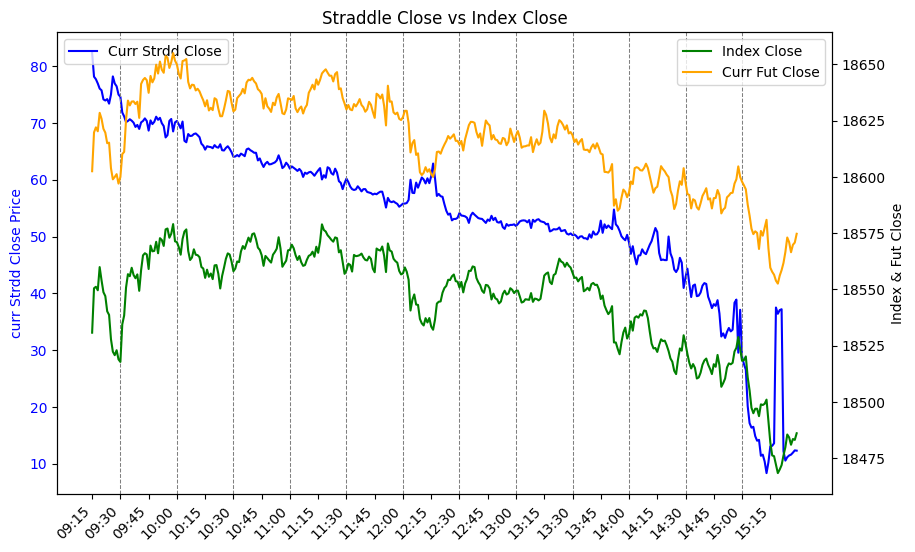

In [156]:
# Filter for times with a 15-minute interval for X-Label correct display of time
strdd_df['time'] = pd.to_datetime(strdd_df['time'], format='%H:%M:%S')
strdd_df['minute'] = strdd_df['time'].dt.minute
interval_df = strdd_df[strdd_df['minute'] % 15 == 0]

# Filter for 30-minute intervals for vertical lines
lines_df = strdd_df[strdd_df['minute'] % 30 == 0]

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot curr_strdd_close on the first y-axis
ax1.plot(strdd_df['time'], strdd_df['curr_strdd_close'], color='blue', label='Curr Strdd Close')
ax1.set_ylabel('curr Strdd Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(strdd_df['time'], strdd_df['index_close'], color='green', label='Index Close')

ax2.plot(strdd_df['time'], strdd_df['curr_fut_close'], color='orange', label='Curr Fut Close')
ax2.set_ylabel('Index & Fut Close', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set x-axis to show only 15-minute intervals
ax1.set_xticks(interval_df['time'])
ax1.set_xticklabels(interval_df['time'].dt.strftime('%H:%M'), rotation=45, ha='right')

# Adding vertical dotted lines every 30 minutes
for line_time in lines_df['time']:
    ax1.axvline(x=line_time, color='gray', linestyle='--', linewidth=0.75)

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Title and labels
plt.title('Straddle Close vs Index Close')
plt.xlabel('Time')

plt.show()

Next Plann to find the straddle chart for next expiry amd for monthly expiry

In [193]:
curr_date

Timestamp('2023-06-01 00:00:00')

In [195]:
next_expiry = next_to_next_expiry_date(curr_date)

In [201]:
next_index_fut_df = index_fut_df.copy()

In [202]:
next_index_fut_df['strike_price'] = round(next_index_fut_df['curr_fut_close']/50)*50

In [208]:
#Filtering call option data for current expiry and only keep required features
next_call = data[(data['exp_date']==next_expiry) & (data['option_type'] == 'CE')][['date', 'time', 'strike_price', 'close']]
next_call.rename(columns={'close':'next_ce_close'}, inplace=True)
#Filtering put option data for current expiry and only keep required features
next_put = data[(data['exp_date']==next_expiry) & (data['option_type'] == 'PE')][['date', 'time', 'strike_price', 'close']]
next_put.rename(columns={'close':'next_pe_close'}, inplace=True)

In [213]:
next_strdd_df = next_index_fut_df.merge(next_call, on=['date', 'time', 'strike_price']).merge(next_put, on=['date', 'time', 'strike_price'])

next_strdd_df['strdd_close'] = next_strdd_df['next_ce_close'] + next_strdd_df['next_pe_close'] 

In [210]:
next_strdd_df

,symbol,date,time,index_close,curr_fut_close,strike_price,next_ce_close,next_pe_close,next_strdd_close
0,NIFTY,2023-06-01,09:15:00,18530.80,18602.55,18600.0,86.65,131.45,218.10
1,NIFTY,2023-06-01,09:16:00,18550.55,18619.80,18600.0,94.00,121.40,215.40
2,NIFTY,2023-06-01,09:17:00,18551.20,18622.05,18600.0,94.20,120.40,214.60
3,NIFTY,2023-06-01,09:18:00,18549.65,18620.30,18600.0,93.80,122.10,215.90
4,NIFTY,2023-06-01,09:19:00,18559.95,18628.50,18650.0,74.00,143.90,217.90
...,...,...,...,...,...,...,...,...,...
370,NIFTY,2023-06-01,15:25:00,18484.25,18571.00,18550.0,88.00,119.20,207.20
371,NIFTY,2023-06-01,15:26:00,18481.00,18566.55,18550.0,86.85,122.65,209.50
372,NIFTY,2023-06-01,15:27:00,18483.55,18569.85,18550.0,88.30,120.70,209.00
373,NIFTY,2023-06-01,15:28:00,18483.15,18570.85,18550.0,88.15,120.70,208.85


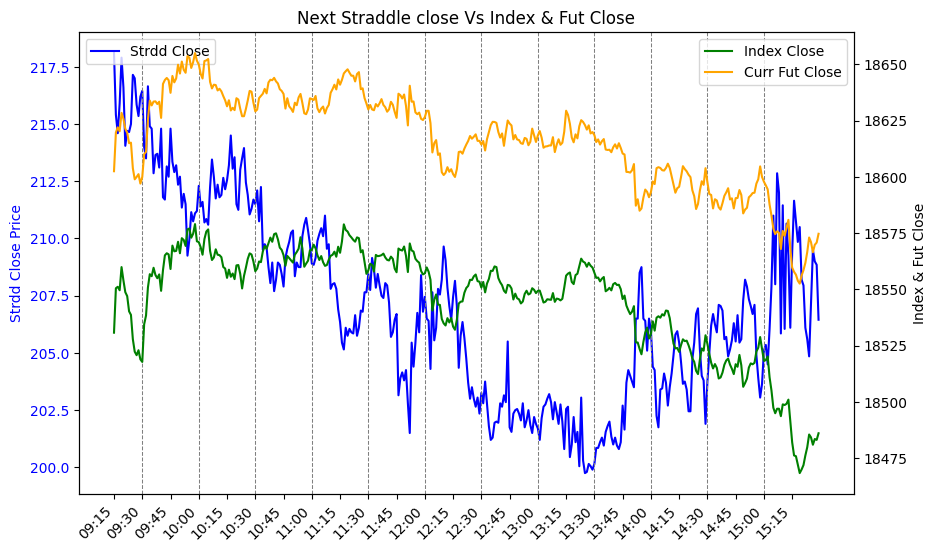

In [219]:
plot_and_save_straddle_vs_index(next_strdd_df, r'E:\\Key_Indicator_Stock_Market\\test.png', 'Next Straddle close Vs Index & Fut Close')

In [216]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_and_save_straddle_vs_index(strdd_df, save_path, title):
    # Convert the time column to datetime format
    strdd_df['time'] = pd.to_datetime(strdd_df['time'], format='%H:%M:%S')

    # Filter for times with a 15-minute interval for correct display of time on X-Label
    interval_df = strdd_df[strdd_df['time'].dt.minute % 15 == 0]

    # Filter for 30-minute intervals for vertical lines
    lines_df = strdd_df[strdd_df['time'].dt.minute % 30 == 0]

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot curr_strdd_close on the first y-axis
    ax1.plot(strdd_df['time'], strdd_df['strdd_close'], color='blue', label='Strdd Close')
    ax1.set_ylabel('Strdd Close Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()
    ax2.plot(strdd_df['time'], strdd_df['index_close'], color='green', label='Index Close')
    ax2.plot(strdd_df['time'], strdd_df['curr_fut_close'], color='orange', label='Curr Fut Close')
    ax2.set_ylabel('Index & Fut Close', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Set x-axis to show only 15-minute intervals
    ax1.set_xticks(interval_df['time'])
    ax1.set_xticklabels(interval_df['time'].dt.strftime('%H:%M'), rotation=45, ha='right')

    # Adding vertical dotted lines every 30 minutes
    for line_time in lines_df['time']:
        ax1.axvline(x=line_time, color='gray', linestyle='--', linewidth=0.75)

    # Adding legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Title and labels
    plt.title(title)
    plt.xlabel('Time')

    # Save the plot to the specified path
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# Example usage:
# plot_and_save_straddle_vs_index(strdd_df, 'path/to/save/plot.png')


#### Monthly Straddle Calculation

In [220]:
curr_monthly_expiry_date(curr_date)

Timestamp('2023-06-29 00:00:00')

In [221]:
monthly_exp = curr_monthly_expiry_date(curr_date)
monthly_index_fut_df = index_fut_df.copy()
monthly_index_fut_df['strike_price'] = round(next_index_fut_df['curr_fut_close']/50)*50
#Filtering call option data for current expiry and only keep required features
call_opt = data[(data['exp_date']==monthly_exp) & (data['option_type'] == 'CE')][['date', 'time', 'strike_price', 'close']]
call_opt.rename(columns={'close':'ce_close'}, inplace=True)
#Filtering put option data for current expiry and only keep required features
put_opt = data[(data['exp_date']==monthly_exp) & (data['option_type'] == 'PE')][['date', 'time', 'strike_price', 'close']]
put_opt.rename(columns={'close':'pe_close'}, inplace=True)
monthly_strdd_df = monthly_index_fut_df.merge(call_opt, on=['date', 'time', 'strike_price']).merge(put_opt, on=['date', 'time', 'strike_price'])

monthly_strdd_df['strdd_close'] = monthly_strdd_df['ce_close'] + monthly_strdd_df['pe_close'] 

In [222]:
monthly_strdd_df

,symbol,date,time,index_close,curr_fut_close,strike_price,ce_close,pe_close,strdd_close
0,NIFTY,2023-06-01,09:15:00,18530.80,18602.55,18600.0,208.40,203.55,411.95
1,NIFTY,2023-06-01,09:16:00,18550.55,18619.80,18600.0,216.40,195.00,411.40
2,NIFTY,2023-06-01,09:17:00,18551.20,18622.05,18600.0,218.15,194.00,412.15
3,NIFTY,2023-06-01,09:18:00,18549.65,18620.30,18600.0,216.85,195.70,412.55
4,NIFTY,2023-06-01,09:19:00,18559.95,18628.50,18650.0,194.40,213.60,408.00
...,...,...,...,...,...,...,...,...,...
370,NIFTY,2023-06-01,15:25:00,18484.25,18571.00,18550.0,213.70,194.35,408.05
371,NIFTY,2023-06-01,15:26:00,18481.00,18566.55,18550.0,212.50,196.45,408.95
372,NIFTY,2023-06-01,15:27:00,18483.55,18569.85,18550.0,213.15,197.05,410.20
373,NIFTY,2023-06-01,15:28:00,18483.15,18570.85,18550.0,214.00,195.60,409.60


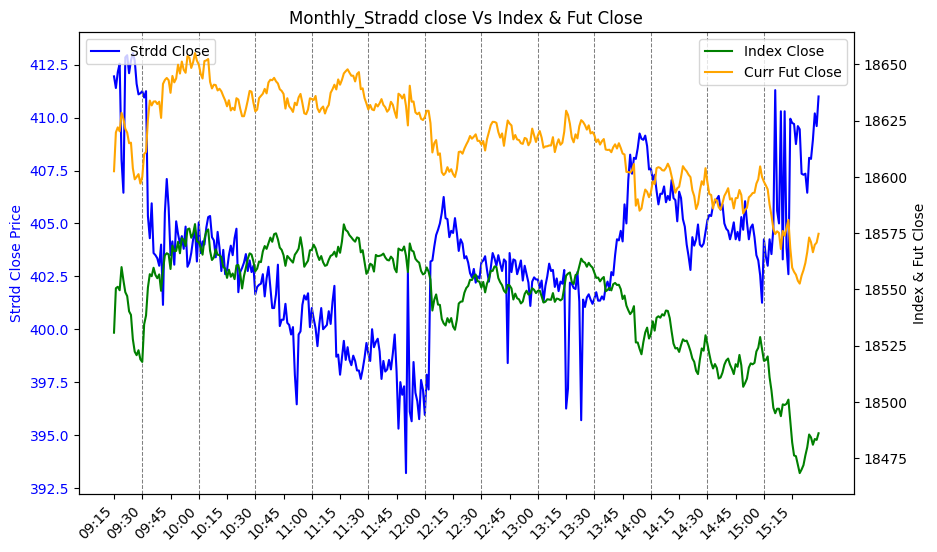

In [223]:
plot_and_save_straddle_vs_index(monthly_strdd_df, r"E:\\Key_Indicator_Stock_Market\\.test_monthly.png", "Monthly_Stradd close Vs Index & Fut Close")

In [ ]:
def next_to_next_expiry_date(current_date):

  ''' 
  This Finction will find the 'NEXT TO NEXT EXPIRY DATE' for Nifty 50
  THe expiry date will occurs on thrusday, if there is holyday on thrusday then expiry date will be 
  the prier to the thrusday

    input format: Timestamp('2023-06-01 00:00:00')
    output format: Timestamp('2023-06-08 00:00:00')
  
  '''
  # Extract Year from timestamp format
  yr = current_date.year

  # Find the weekday of the current date (0=Monday, 1=Tuesday, ..., 6=Sunday)
  weekday_current = current_date.weekday()

  days_to_next_next_thursday = 7 + (3 - weekday_current) % 7 # 7 added because we have to find the next to next Thrusday

    # Find the next Thursday
  next_to_next_thursday = current_date + pd.Timedelta(days=days_to_next_next_thursday)

  # Adjust for holidays: if Thursday is a holiday, shift to the previous day
  next_expiry_date = next_to_next_thursday

  while next_expiry_date.strftime('%Y-%m-%d') in holidays.holidays(yr):
      next_expiry_date -= timedelta(days=1)
      
  return next_expiry_date
